In [1]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
def showGraph(data):
    plt.figure()
    plt.plot(data)
    plt.show()
def saveGraph(data, file_name):
    plt.figure(dpi=360)
    plt.plot(data)
    plt.savefig('results/' + file_name)
# convert dataset to x and y
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
def relative_error(xs, ys):
    error = 0
    zero = 0
    for i in range(len(xs)):
        if ys[i] != 0:
            error += abs(xs[i]-ys[i])*100 / ys[i]
        else:
            zero += 1
    error /= (len(xs) - zero)
    return error
def read_data(file_name):
    return pandas.read_csv('datas/' + file_name, usecols=[1], sep='|')

In [3]:
dataset = pandas.read_csv('datas/data_stock_market.csv', sep='|', usecols=[1])
data_standard = dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [4]:
trainSize = int(len(dataset)*0.67)
train = dataset[0:trainSize] # from 02/11/2012 -> 19/01/2016
test = dataset[trainSize:]  # from 20/01/2016

In [9]:
print('train')
print(train[len(train)-5:])
print('test')
print(test[:5])

train
[[ 0.44314373]
 [ 0.42557215]
 [ 0.40165661]
 [ 0.3617495 ]
 [ 0.38425261]]
test
[[ 0.36909892]
 [ 0.35100067]
 [ 0.35186249]
 [ 0.40000479]
 [ 0.38894475]]


In [6]:
look_back = 3

In [10]:
trainX = []
for i in list(range(0, len(train) - look_back)):
    trainX.append([train[i], train[i+1], train[i+2]])
#     trainX.append([train.loc[i], train.loc[i+1], train.loc[i+2]])
trainX = numpy.array(trainX)
print(trainX) # each elements of trainX has type [x(t), x(t+1), x(t+2)] with x(t) is the close price of date t.
# trainX[-1] = [x(14/01/2016), x(15/01/2016), x(18/01/2016)]

[[[ 0.        ]
  [ 0.00481184]
  [ 0.00404577]]

 [[ 0.00481184]
  [ 0.00404577]
  [ 0.01350187]]

 [[ 0.00404577]
  [ 0.01350187]
  [ 0.02475342]]

 ..., 
 [[ 0.45245619]
  [ 0.44314373]
  [ 0.42557215]]

 [[ 0.44314373]
  [ 0.42557215]
  [ 0.40165661]]

 [[ 0.42557215]
  [ 0.40165661]
  [ 0.3617495 ]]]


In [12]:
trainY = numpy.array(train[3:])
print(trainY) # trainY[0]: the close price of date 07/11/2012 (380.90), trainY[-1] = close price of date 19/01/2016 (535.77)

[[ 0.01350187]
 [ 0.02475342]
 [ 0.02741071]
 [ 0.03198315]
 [ 0.02384372]
 [ 0.02980465]
 [ 0.0278895 ]
 [ 0.02501676]
 [ 0.01929522]
 [ 0.02355645]
 [ 0.02061189]
 [ 0.01905583]
 [ 0.01544097]
 [ 0.00632002]
 [ 0.00390214]
 [ 0.00126879]
 [ 0.00703821]
 [ 0.00612851]
 [ 0.00959973]
 [ 0.0163746 ]
 [ 0.02496888]
 [ 0.02496888]
 [ 0.02044432]
 [ 0.02736283]
 [ 0.03377861]
 [ 0.03787226]
 [ 0.03813559]
 [ 0.04057742]
 [ 0.04397683]
 [ 0.04340228]
 [ 0.05585081]
 [ 0.05846021]
 [ 0.05151776]
 [ 0.05853203]
 [ 0.06243417]
 [ 0.07382936]
 [ 0.08309394]
 [ 0.09209518]
 [ 0.10315522]
 [ 0.10535766]
 [ 0.12161256]
 [ 0.14107536]
 [ 0.17212487]
 [ 0.17597912]
 [ 0.20315044]
 [ 0.20930288]
 [ 0.2003974 ]
 [ 0.20626257]
 [ 0.21543139]
 [ 0.19510677]
 [ 0.18888251]
 [ 0.17363306]
 [ 0.16180695]
 [ 0.16305181]
 [ 0.18466916]
 [ 0.2222302 ]
 [ 0.24978454]
 [ 0.26034186]
 [ 0.26893613]
 [ 0.25023939]
 [ 0.25892943]
 [ 0.25643972]
 [ 0.2444221 ]
 [ 0.27075553]
 [ 0.27616585]
 [ 0.28432922]
 [ 0.28413

In [14]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
print(trainX)

[[[ 0.          0.00481184  0.00404577]]

 [[ 0.00481184  0.00404577  0.01350187]]

 [[ 0.00404577  0.01350187  0.02475342]]

 ..., 
 [[ 0.45245619  0.44314373  0.42557215]]

 [[ 0.44314373  0.42557215  0.40165661]]

 [[ 0.42557215  0.40165661  0.3617495 ]]]


In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
3s - loss: 0.0048
Epoch 2/100
2s - loss: 3.9960e-04
Epoch 3/100
3s - loss: 4.0401e-04
Epoch 4/100
3s - loss: 3.8076e-04
Epoch 5/100
2s - loss: 3.7745e-04
Epoch 6/100
2s - loss: 3.7356e-04
Epoch 7/100
2s - loss: 3.3706e-04
Epoch 8/100
2s - loss: 3.3461e-04
Epoch 9/100
2s - loss: 3.2715e-04
Epoch 10/100
2s - loss: 2.9452e-04
Epoch 11/100
3s - loss: 3.3382e-04
Epoch 12/100
2s - loss: 2.9526e-04
Epoch 13/100
2s - loss: 3.0334e-04
Epoch 14/100
2s - loss: 2.9147e-04
Epoch 15/100
2s - loss: 2.7213e-04
Epoch 16/100
2s - loss: 2.9310e-04
Epoch 17/100
2s - loss: 2.6334e-04
Epoch 18/100
2s - loss: 2.6839e-04
Epoch 19/100
2s - loss: 2.6372e-04
Epoch 20/100
2s - loss: 3.0101e-04
Epoch 21/100
2s - loss: 2.9408e-04
Epoch 22/100
3s - loss: 2.6952e-04
Epoch 23/100
2s - loss: 2.7370e-04
Epoch 24/100
3s - loss: 2.7675e-04
Epoch 25/100
2s - loss: 2.6486e-04
Epoch 26/100
2s - loss: 2.3923e-04
Epoch 27/100
2s - loss: 2.6034e-04
Epoch 28/100
2s - loss: 2.6036e-04
Epoch 29/100
3s - loss: 2.5002e-0

In [37]:
testX = []
for i in list(range(0, len(test) - look_back)):
    testX.append([test[i], test[i+1], test[i+2]])
testX = numpy.array(testX)
# start from date 20/01/2016, testX[0] = [x(20/01/2016), x(21/01/2016), x(22/01/2016)]
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(testX)

[[[ 0.36909892  0.35100067  0.35186249]]

 [[ 0.35100067  0.35186249  0.40000479]]

 [[ 0.35186249  0.40000479  0.38894475]]

 ..., 
 [[ 0.95319831  0.94996648  0.95975773]]

 [[ 0.94996648  0.95975773  0.94752466]]

 [[ 0.95975773  0.94752466  0.95353347]]]


In [32]:
testY = numpy.array(test[3:])
print(testY)

[[ 0.40000479]
 [ 0.38894475]
 [ 0.40081873]
 [ 0.39311022]
 [ 0.40694724]
 [ 0.39571962]
 [ 0.38588049]
 [ 0.39215264]
 [ 0.399526  ]
 [ 0.40575026]
 [ 0.40345207]
 [ 0.41365029]
 [ 0.41125634]
 [ 0.42427942]
 [ 0.4279661 ]
 [ 0.44395767]
 [ 0.44532223]
 [ 0.46150531]
 [ 0.44900891]
 [ 0.45688499]
 [ 0.44074978]
 [ 0.44599253]
 [ 0.46662836]
 [ 0.46713109]
 [ 0.47493536]
 [ 0.48103993]
 [ 0.47747295]
 [ 0.4702911 ]
 [ 0.48034569]
 [ 0.48357752]
 [ 0.48530116]
 [ 0.475869  ]
 [ 0.48312267]
 [ 0.48836541]
 [ 0.48013023]
 [ 0.47163172]
 [ 0.46837595]
 [ 0.47747295]
 [ 0.46777746]
 [ 0.47117686]
 [ 0.47989084]
 [ 0.46207986]
 [ 0.465982  ]
 [ 0.44517859]
 [ 0.43849947]
 [ 0.43225127]
 [ 0.44302404]
 [ 0.46090683]
 [ 0.47002777]
 [ 0.47179929]
 [ 0.48838935]
 [ 0.4897539 ]
 [ 0.48539692]
 [ 0.48891602]
 [ 0.48980178]
 [ 0.46207986]
 [ 0.46148138]
 [ 0.47991478]
 [ 0.52001341]
 [ 0.51785885]
 [ 0.53437709]
 [ 0.52355645]
 [ 0.51807431]
 [ 0.53411376]
 [ 0.53578952]
 [ 0.54163076]
 [ 0.55362

391

In [50]:
predict = []
for i in testX:
    predict.append(model.predict(numpy.array([i]))[0][0])
predict = numpy.array(predict)
print(predict)

[ 0.35239583  0.39939836  0.39305153  0.40150169  0.39562556  0.40773103
  0.39851144  0.3875201   0.39308414  0.4011322   0.40752012  0.40556067
  0.41489449  0.4136017   0.42547855  0.43029249  0.4454515   0.4480004
  0.462982    0.45227495  0.45800239  0.44375569  0.44701812  0.46814886
  0.47016421  0.4767195   0.48325738  0.47994548  0.47241926  0.48166606
  0.48601019  0.48743644  0.47833273  0.48442477  0.49058455  0.48272052
  0.47357503  0.47011861  0.47902459  0.47062346  0.47261328  0.48179266
  0.46521279  0.46700317  0.44819951  0.43979207  0.43415132  0.44426841
  0.46277055  0.47261572  0.47422758  0.48994228  0.49258465  0.4876444
  0.49059448  0.49197277  0.46520895  0.46219781  0.48127142  0.52175134
  0.52200407  0.53556114  0.5266068   0.51951742  0.53512394  0.53837764
  0.54323626  0.55519372  0.54966289  0.55121052  0.57263303  0.56971055
  0.56504118  0.57650578  0.59836447  0.59399366  0.58473223  0.57436413
  0.56530517  0.56656569  0.56784594  0.55043048  0.5

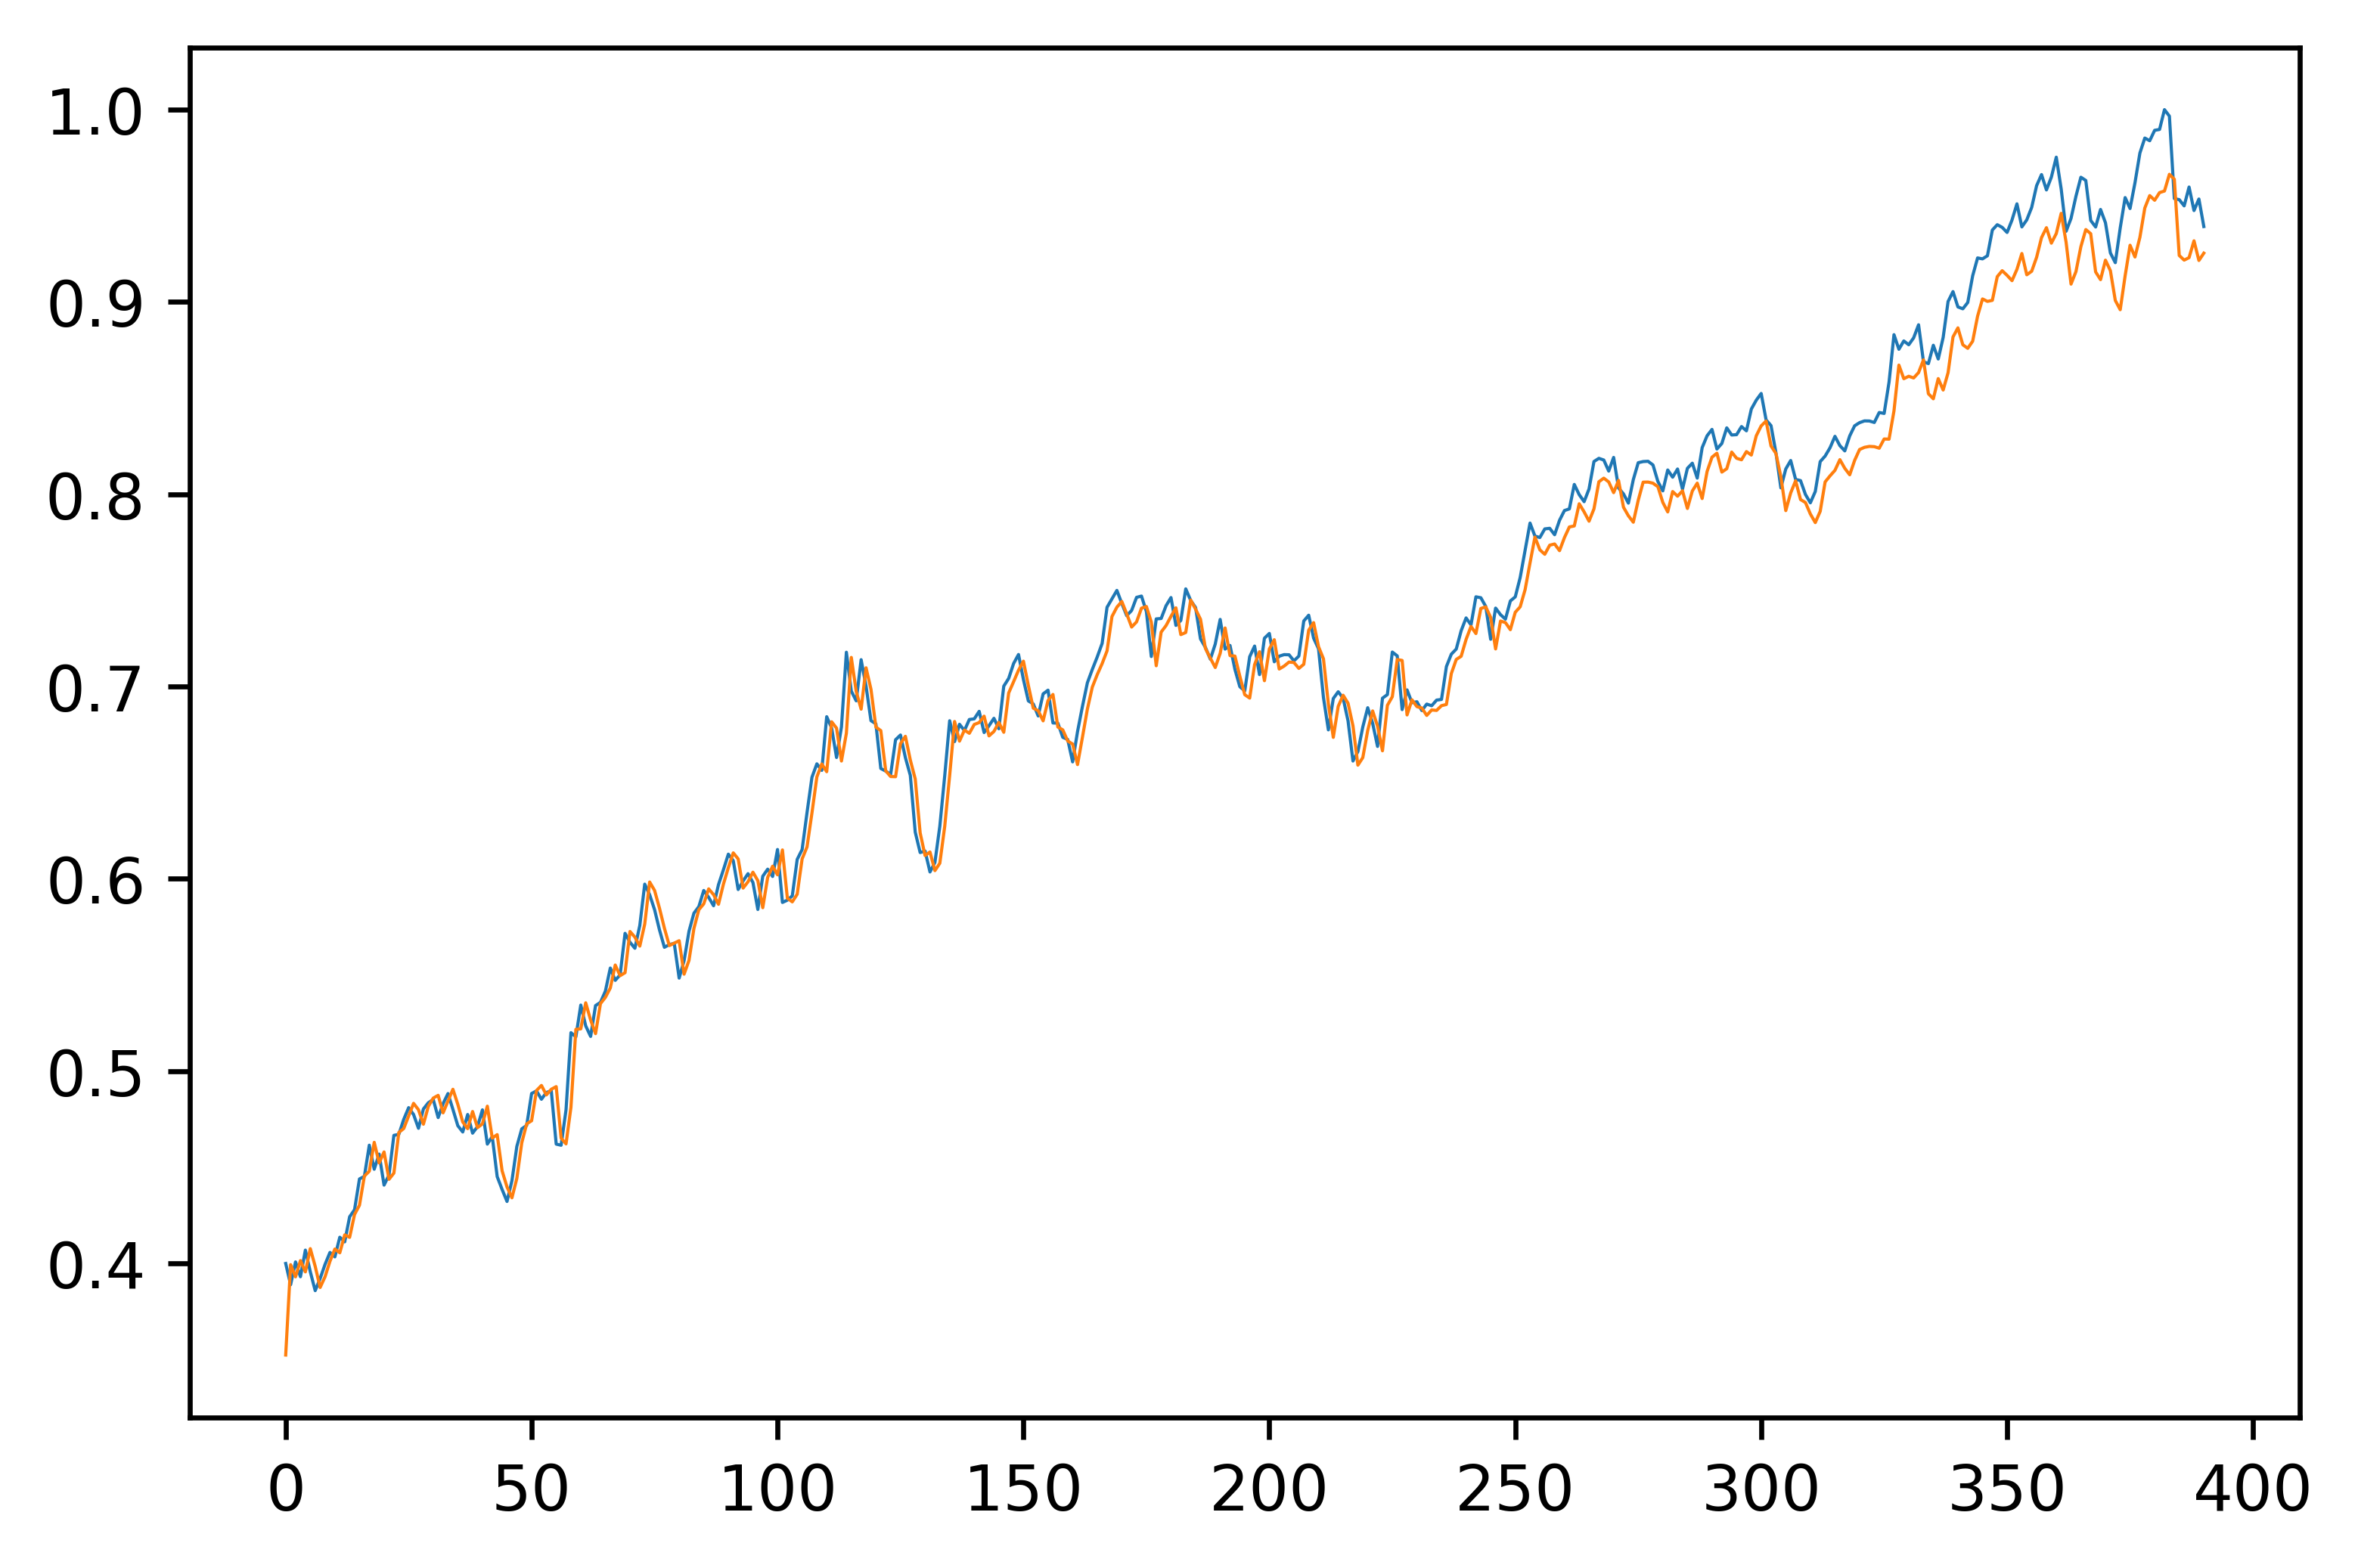

In [52]:
plt.figure(dpi=600)
plt.plot(testY, linewidth=0.5)
plt.plot(predict, linewidth=0.5)
plt.show()

In [48]:
# model.predict(testX)

array([[ 0.35239586],
       [ 0.39939839],
       [ 0.39305153],
       [ 0.40150163],
       [ 0.39562553],
       [ 0.40773103],
       [ 0.39851144],
       [ 0.38752007],
       [ 0.39308417],
       [ 0.40113214],
       [ 0.40752015],
       [ 0.40556058],
       [ 0.41489449],
       [ 0.41360173],
       [ 0.42547852],
       [ 0.43029252],
       [ 0.44545147],
       [ 0.44800043],
       [ 0.46298203],
       [ 0.45227495],
       [ 0.45800236],
       [ 0.44375572],
       [ 0.44701812],
       [ 0.4681488 ],
       [ 0.47016418],
       [ 0.47671953],
       [ 0.48325732],
       [ 0.47994545],
       [ 0.4724192 ],
       [ 0.48166606],
       [ 0.48601019],
       [ 0.48743638],
       [ 0.47833267],
       [ 0.48442477],
       [ 0.49058452],
       [ 0.48272052],
       [ 0.47357503],
       [ 0.47011855],
       [ 0.47902456],
       [ 0.47062352],
       [ 0.4726133 ],
       [ 0.48179272],
       [ 0.46521279],
       [ 0.4670032 ],
       [ 0.44819951],
       [ 0

In [ ]:
predi